In [8]:
import os
import numpy as np
import pandas as pd
import yaml
import bayes_opt
from chspy import CubicHermiteSpline
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from scipy.optimize import NonlinearConstraint
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot



# Define the path for saving/loading optimization progress
SAVE_PATH = "/Users/nathanirniger/Desktop/Bayes/bayesian_optimization_progress.json"

# Track scores for real-time visualization
score_history = []


In [ ]:
def cubic_hermite_spline(points):
    spline = CubicHermiteSpline(n=1)
    for t, value, derivative in points:
        spline.add((t, [value], [derivative]))
    return spline

def validate_constraints(force1_end_time, force2_start_time, force2_peak_time, force2_end_time):
    if force2_end_time <= force2_start_time:
        return False
    if force2_end_time <= force2_peak_time:
        return False
    if force2_peak_time <= force2_start_time:
        return False
    return True

def save_optimization_results(base_profile, score, force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time):
    try:
        os.makedirs("/Users/nathanirniger/Desktop/profiles/optim/plots", exist_ok=True)
    except Exception as e:
        print(f"Error creating directories: {e}")

    # Save the profile as CSV
    profile_path = f"/Users/nathanirniger/Desktop/profiles/optim/score_{score}_profile.csv"
    base_profile.to_csv(profile_path, index=False)

    # Plot the profile and save the figure
    target_profile = pd.read_csv("/Users/nathanirniger/Desktop/profiles/reference_profile_3.csv")
    plt.figure(figsize=(10, 6))
    plt.plot(base_profile["force_X"], label="Optimized Profile X Force")
    plt.plot(base_profile["force_Y"], label="Optimized Profile Y Force")
    plt.plot(target_profile["force_X"], label="Target Profile X Force", linestyle="--")
    plt.plot(target_profile["force_Y"], label="Target Profile Y Force", linestyle="--")
    plt.legend()
    plt.title(f"Score: {score}")
    plt.savefig(f"/Users/nathanirniger/Desktop/profiles/optim/plots/score_{score}_profile_t11_{force1_end_time}_f1_{force1_peak_force}_t21_{force2_start_time}_t22_{force2_peak_time}_f21_{force2_peak_force}_t23_{force2_end_time}.png")
    plt.close()

def plot_scores():
    plt.figure(figsize=(10, 6))
    plt.plot(score_history, label="Score History")
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title("Optimization Score Trend")
    plt.legend()
    plt.show()

In [3]:
def get_profile(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time):
    max_force = 65  # Maximum force for the profile
    max_time = 360  # Maximum time for the profile

    force1_end_time = force1_end_time * max_time
    force1_peak_force = force1_peak_force * max_force

    force2_start_time = force2_start_time * max_time
    force2_peak_time = force2_peak_time * max_time
    force2_peak_force = force2_peak_force * max_force
    force2_end_time = force2_end_time * max_time

    # Load calibration data
    calibration_path = "/Users/nathanirniger/Desktop/profiles/device_height_calibration.yaml"
    with open(calibration_path, 'r') as file:
        data = yaml.safe_load(file)

    length = len(data['theta_2_values'])
    base_profile = pd.DataFrame({"force_X": np.zeros(length), "force_Y": np.zeros(length), "theta_2": data['theta_2_values']})

    # X Force Profile
    grf_x = cubic_hermite_spline([(0, 0, 0), (force1_end_time / 2, force1_peak_force, 0), (force1_end_time, 0, 0)])
    curve_x = [grf_x.get_state(i)[0] for i in range(int(np.round(force1_end_time)))]
    padded_curve_x = np.concatenate([curve_x, np.zeros(length - len(curve_x))])
    
    # Y Force Profile
    grf_y = cubic_hermite_spline([(0, 0, 0), (force2_peak_time - force2_start_time, force2_peak_force, 0), (force2_end_time - force2_start_time, 0, 0)])
    curve_y = [grf_y.get_state(i)[0] for i in range(int(np.round(force2_end_time - force2_start_time)))]
    padded_curve_y = np.concatenate([np.zeros(int(np.round(force2_start_time))), curve_y, np.zeros(length - len(curve_y) - int(np.round(force2_start_time)))])

    base_profile["force_X"] = padded_curve_x
    base_profile["force_Y"] = padded_curve_y

    return base_profile

In [4]:
def easy_score(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time):
    force1_end_time_target = 0.8
    force1_peak_force_target = 0.5

    force2_start_time_target = 0.2
    force2_peak_time_target = 0.5
    force2_peak_force_target = 0.8
    force2_end_time_target = 0.7

    # score = np.abs(force1_end_time - force1_end_time_target) + np.abs(force1_peak_force - force1_peak_force_target) + np.abs(force2_start_time - force2_start_time_target) + np.abs(force2_peak_time - force2_peak_time_target) + np.abs(force2_peak_force - force2_peak_force_target) + np.abs(force2_end_time - force2_end_time_target)
    score = (force1_end_time - force1_end_time_target)**2 + (force1_peak_force - force1_peak_force_target)**2 + (force2_start_time - force2_start_time_target)**2 + (force2_peak_time - force2_peak_time_target)**2 + (force2_peak_force - force2_peak_force_target)**2 + (force2_end_time - force2_end_time_target)**2
    return -score

In [5]:
def objective(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time):

    # Constraint: Ensure valid parameter relationships
    if not validate_constraints(force1_end_time, force2_start_time, force2_peak_time, force2_end_time):
        return -1 # Penalty for violating constraints

    base_profile = get_profile(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time)
    score = easy_score(force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time)

    # Log scores for visualization
    score_history.append(score)
    # Log results
    if score > -0.05:
        save_optimization_results(base_profile, score, force1_end_time, force1_peak_force, force2_start_time, force2_peak_time, force2_peak_force, force2_end_time)

    return score

In [6]:
pbounds = {
    "force1_end_time": (0.0, 1.0),        # End time for force1
    "force1_peak_force": (0.0, 1.0),      # Ratio for force1 peak time
    "force2_start_time": (0.0, 1.0),      # Start time for force2
    "force2_peak_time": (0.0, 1.0),       # Peak time for force2
    "force2_peak_force": (0.0, 1.0),      # Peak force for force2
    "force2_end_time": (0.0, 1.0)         # End time for force2
}


def load_optimizer(kappa):
    # constraint = NonlinearConstraint(constraint_func, lb=-1, ub=0)
    acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,                   # Parameter bounds
        acquisition_function=acquisition,  # Acquisition function: Upper Confidence Bound
        # constraint=constraint,             # Constraint
        random_state=0,                    # Random seed accepts integer value and is used for reproducibility.
        verbose=2                          # Verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    )
    
    if os.path.exists(SAVE_PATH):
        load_logs(optimizer, logs=[SAVE_PATH])
        print("Loaded optimization progress from file.")
    else:
        print("No saved progress found. Starting a new optimization.")
        
    return optimizer

# Save progress using a JSONLogger
def save_progress(optimizer):
    logger = JSONLogger(path=SAVE_PATH)
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)


def explorate(optimizer, init_points=10, n_iter=0):
    optimizer.maximize(
        init_points=init_points,  # Number of random initial points
        n_iter=n_iter,            # Number of optimization iterations
    )

def optimize(optimizer, init_points=0, n_iter=1):
    optimizer.maximize(
        init_points=init_points,  # Number of random initial points
        n_iter=n_iter,            # Number of optimization iterations
    )


No saved progress found. Starting a new optimization.
Best parameters found: {'force1_end_time': 0.7787690523238213, 'force1_peak_force': 0.42001610100369957, 'force2_end_time': 0.5739337543534424, 'force2_peak_force': 0.7266281218940647, 'force2_peak_time': 0.5765528702129388, 'force2_start_time': 0.14842833471425265}
Best score: -0.036644286624273666


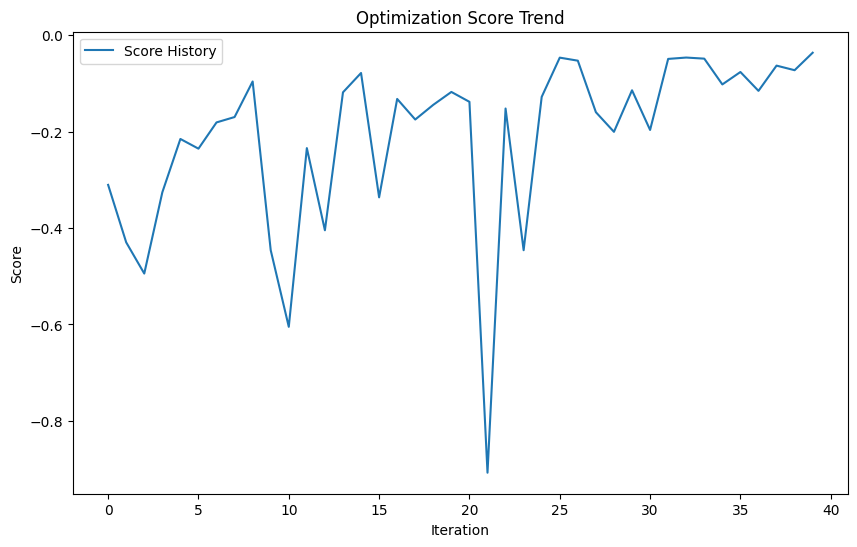

In [7]:
optimizer = load_optimizer(kappa=2.5)
save_progress(optimizer)

# Run initial exploration
explorate(optimizer)

# Run optimization
for i in range(50):
    optimize(optimizer)

# Output the best parameters and score
print("Best parameters found:", optimizer.max["params"])
print("Best score:", optimizer.max["target"])

# Plot the optimization score trend
plot_scores()

In [14]:
def visualize_objective_surface():
    # Use a 2D slice for simplicity (vary two parameters, fix others)
    x = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    y = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    X, Y = np.meshgrid(x, y)

    # Fix other parameters for the visualization
    fixed_force2_start_time = 0.7
    fixed_force2_peak_time = 0.9

    # Compute objective values for each combination of x, y
    Z = np.array([objective(xi, yi, fixed_force2_start_time, fixed_force2_peak_time) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    # Plot the contour
    plt.figure(figsize=(10, 6))
    contour = plt.contourf(X, Y, Z, levels=50, cmap="viridis")
    plt.colorbar(contour, label="Objective Value")
    plt.xlabel("force1_end_time")
    plt.ylabel("force1_peak_force")
    plt.title("Objective Function Surface")
    plt.show()


In [ ]:
def interactive_score_and_std_surface(optimizer, param_x, param_y, pbounds):
    # Fixed target values for other parameters
    force1_end_time_target = 0.8
    force1_peak_force_target = 0.5

    force2_start_time_target = 0.2
    force2_peak_time_target = 0.5
    force2_peak_force_target = 0.8
    force2_end_time_target = 0.7

    kappa = 2.5  # Exploration parameter for the acquisition function
    acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

    # Generate a grid for two parameters
    x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
    y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
    scores = np.zeros((len(x_vals), len(y_vals)))
    stds = np.zeros((len(x_vals), len(y_vals)))

    # Populate grid with scores from the GP model
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            curr_score, curr_std = optimizer._gp.predict(
                [[force2_end_time_target, force2_peak_force_target, y, x, force1_peak_force_target, force1_end_time_target]], 
                # [[force2_end_time_target, force2_peak_force_target, force2_peak_time_target, force2_start_time]],
                return_std=True
            )
            scores[i, j] = curr_score.item()
            stds[i, j] = curr_std.item()

            acquisition_values[i, j] = -1 * acquisition._get_acq(gp=optimizer._gp)(np.array([[force2_end_time_target, force2_peak_force_target, y, x]]).reshape(1, -1)).item()

    # Extract evaluated points from optimizer
    evaluated_x = []
    evaluated_y = []
    evaluated_scores = []
    hover_texts = []

    for res in optimizer.res:
        params = res["params"]
        score = res["target"]

        evaluated_x.append(params[param_x])
        evaluated_y.append(params[param_y])
        evaluated_scores.append(score)

        # Format hover text to include all parameter values and the score
        hover_text = (
            f"<b>Score:</b> {score:.2f}<br>"
            f"<b>force2_start_time:</b> {params['force2_start_time']:.2f}<br>"
            f"<b>force2_peak_time:</b> {params['force2_peak_time']:.2f}<br>"
            f"<b>force2_peak_force:</b> {params['force2_peak_force']:.2f}<br>"
            f"<b>force2_end_time:</b> {params['force2_end_time']:.2f}"
        )
        hover_texts.append(hover_text)

    # Get the best point
    best_params = optimizer.max["params"]
    best_x = best_params[param_x]
    best_y = best_params[param_y]
    best_score = optimizer.max["target"]

    # Interactive score surface plot
    score_fig = go.Figure()

    # Add score surface
    score_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=scores.T,
        colorscale="Viridis",
        colorbar=dict(
            title="Score",
            titleside="right",
            x=1.0,  # Move colorbar slightly right
            len=0.8  # Adjust colorbar length
        ),
        contours=dict(showlabels=True),
        name="Score Surface"
    ))

    # Add evaluated points with hover information
    score_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(
                title="Evaluated Score",
                titleside="right",
                x=1.12,  # Move evaluated points colorbar further right
                len=0.8  # Adjust colorbar length
            ),
        ),
        text=hover_texts,  # Add detailed hover information
        hoverinfo="text",
        name="Evaluated Points"
    ))

    # Add the best point (star)
    score_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the actual target values (circle)
    score_fig.add_trace(go.Scatter(
        x=[force2_start_time_target], y=[force2_peak_time_target],
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='black')
        ),
        name="Target Values",
        text=f"<b>Target</b><br>{param_x}: {force2_start_time_target}<br>{param_y}: {force2_peak_time_target}",
        hoverinfo="text"
    ))

    score_fig.update_layout(
        title="Interactive Score Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),  # Adjust legend position
        template="plotly"
    )

    iplot(score_fig)


    # Interactive standard deviation surface plot
    std_fig = go.Figure()

    # Add standard deviation surface
    std_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=stds.T,
        colorscale="Viridis",
        colorbar=dict(title="Standard Deviation"),
        contours=dict(showlabels=True),
        name="Standard Deviation Surface"
    ))

    # Add evaluated points
    std_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color="red",
            symbol="circle",
            line=dict(width=1, color="black")
        ),
        text=hover_texts,  # Reuse hover information with additional parameters
        hoverinfo="text",
        name="Evaluated Points"
    ))
    
    # Add the best point (star)
    std_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the actual target values (circle)
    std_fig.add_trace(go.Scatter(
        x=[force2_start_time_target], y=[force2_peak_time_target],
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='black')
        ),
        name="Target Values",
        text=f"<b>Target</b><br>{param_x}: {force2_start_time_target}<br>{param_y}: {force2_peak_time_target}",
        hoverinfo="text"
    ))

    std_fig.update_layout(
        title="Interactive Standard Deviation Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template="plotly"
    )

    iplot(std_fig)



    # Interactive acquisition function surface plot
    acq_fig = go.Figure()

    # Add acquisition function surface
    acq_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=acquisition_values.T,
        colorscale="Viridis",
        colorbar=dict(title="Acquisition Function"),
        contours=dict(showlabels=True),
        name="Acquisition Function Surface"
    ))

    # Add evaluated points
    acq_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color="red",
            symbol="circle",
            line=dict(width=1, color="black")
        ),
        text=hover_texts,  # Reuse hover information with additional parameters
        hoverinfo="text",
        name="Evaluated Points"
    ))

    # Add the best point (star)
    acq_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the actual target values (circle)
    acq_fig.add_trace(go.Scatter(
        x=[force2_start_time_target], y=[force2_end_time_target],
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='black')
        ),
        name="Target Values",
        text=f"<b>Target</b><br>{param_x}: {force2_start_time_target}<br>{param_y}: {force2_end_time_target}",
        hoverinfo="text"
    ))

    acq_fig.update_layout(
        title="Interactive Acquisition Function Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template="plotly"
    )

    iplot(acq_fig)

    # save the plot
    score_fig.write_html(f"/Users/nathanirniger/Desktop/plots/score_fig_{param_x}_{param_y}.html")
    std_fig.write_html(f"/Users/nathanirniger/Desktop/plots/std_fig_{param_x}_{param_y}.html")
    acq_fig.write_html(f"/Users/nathanirniger/Desktop/plots/acq_fig_{param_x}_{param_y}.html")

# Example usage:
interactive_score_and_std_surface(optimizer, 'force2_start_time', 'force2_peak_time', pbounds)



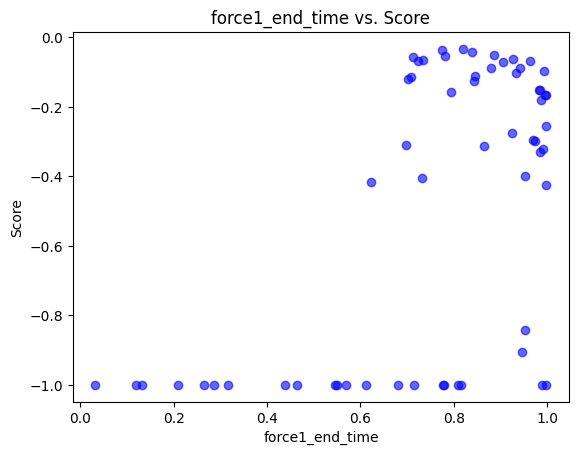

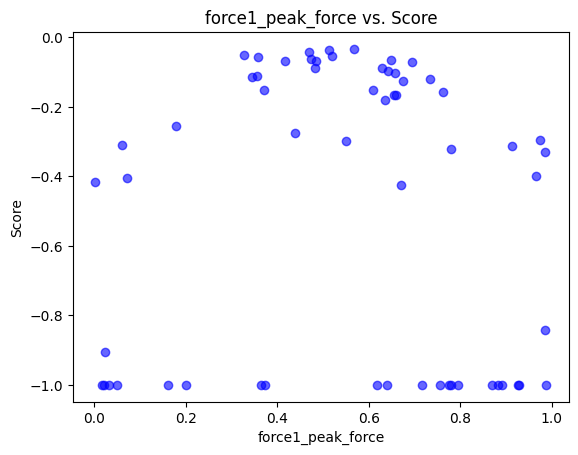

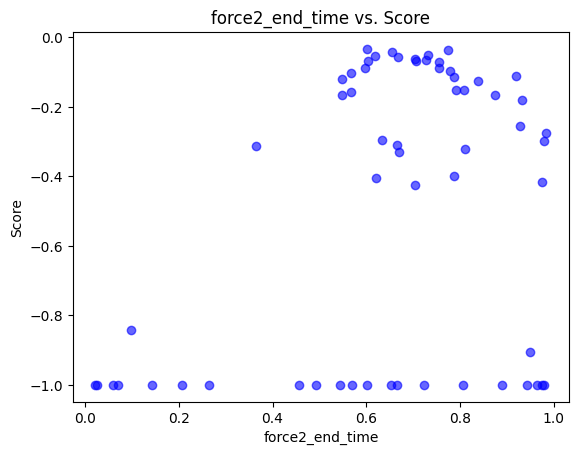

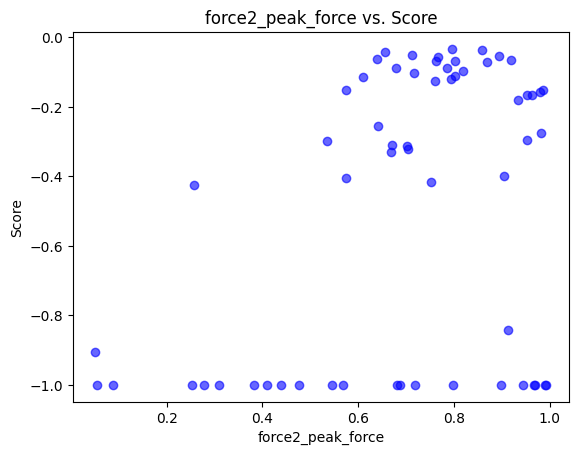

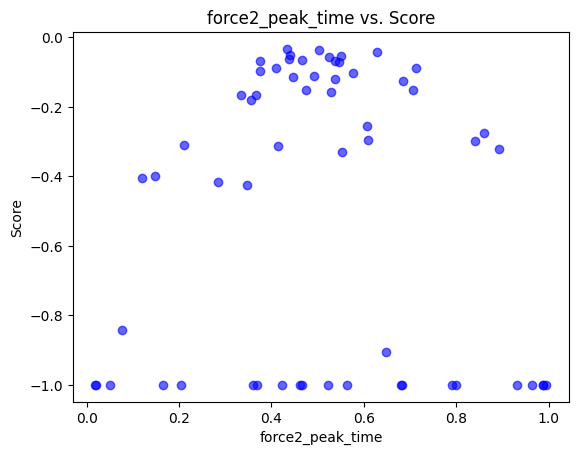

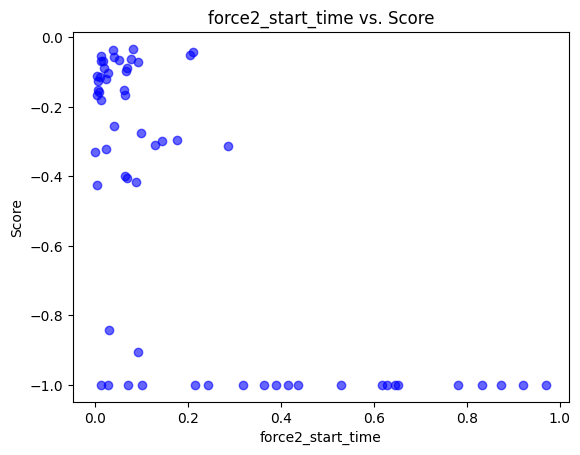

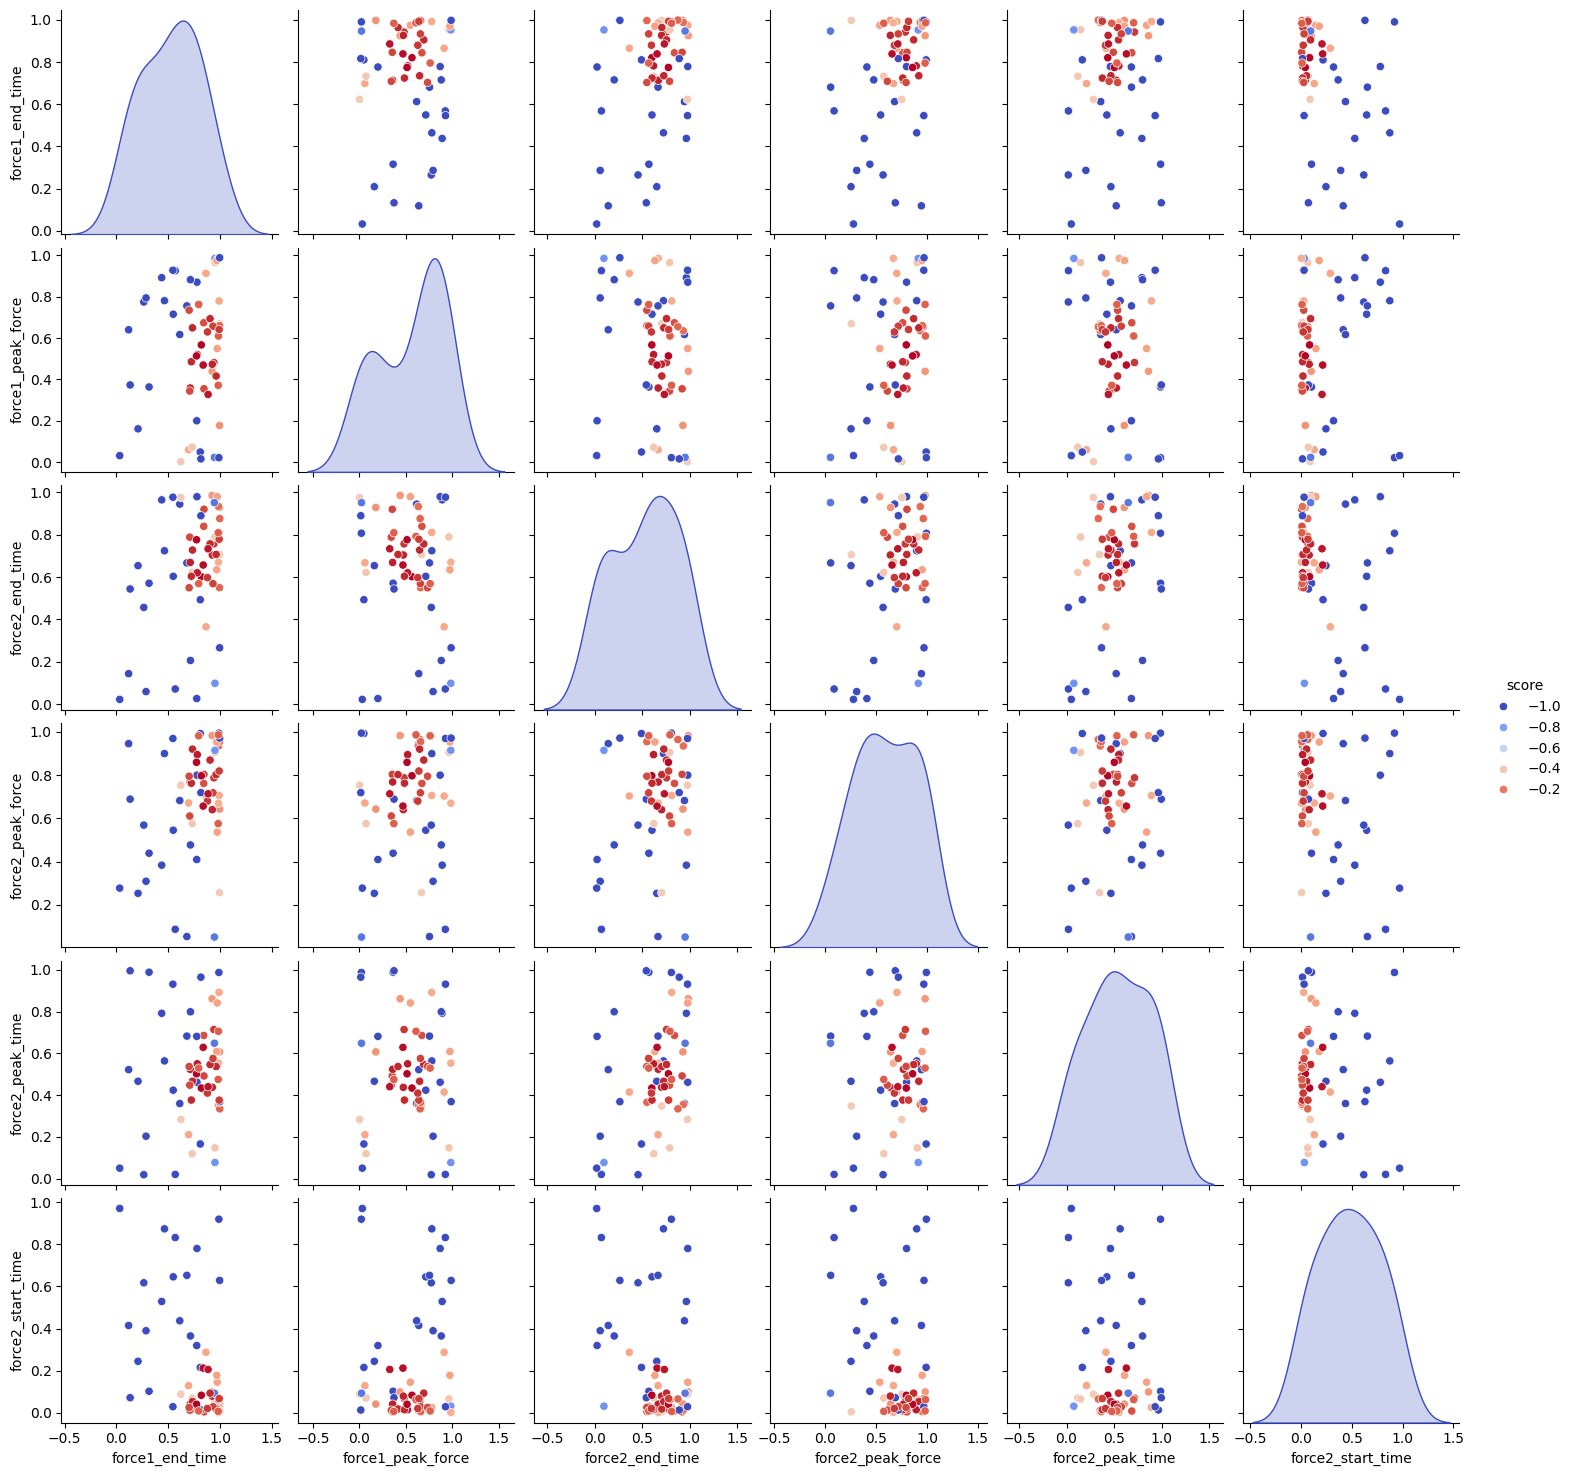

In [16]:
# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame([res['params'] | {'score': res['target']} for res in optimizer.res])

# 1D parameter vs. score plots
for param in results_df.columns[:-1]:  # Exclude score
    plt.figure()
    plt.scatter(results_df[param], results_df['score'], c='blue', alpha=0.6)
    plt.xlabel(param)
    plt.ylabel('Score')
    plt.title(f'{param} vs. Score')
    plt.show()

# 2D pair plots for selected parameters
import seaborn as sns
sns.pairplot(results_df, vars=results_df.columns[:-1], hue='score', palette="coolwarm", diag_kind="kde")
plt.show()

In [ ]:
param_x = 'force1_end_time'
param_y = 'force1_peak_force'

force1_end_time_target = 0.8
force1_peak_force_target = 0.5

force2_start_time_target = 0.2
force2_peak_time_target = 0.5
force2_peak_force_target = 0.8
force2_end_time_target = 0.7

# Generate a grid for two parameters
x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
scores = np.zeros((len(x_vals), len(y_vals)))

# Populate grid with scores from previously evaluated points
for i, x in enumerate(x_vals):
    for j, y in enumerate(y_vals):
        params = {param_x: x, param_y: y}
        # Use the GP model to predict the score at each point
        scores[i, j] = optimizer._gp.predict([[x, y, force2_start_time_target, force2_peak_time_target, force2_peak_force_target, force2_end_time_target]], return_std=False)

plt.imshow(scores, extent=(x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label='Predicted Score')
plt.xlabel(param_x)
plt.ylabel(param_y)
plt.title('Heatmap of Predicted Score')
plt.show()

ValueError: X has 2 features, but GaussianProcessRegressor is expecting 6 features as input.